<a href="https://colab.research.google.com/github/o4lc/PINN-CBF/blob/main/DI/DI_NCBF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##We implement the training method for Neural Control Barrier Functions

In [ ]:
!pip install dill
import dill

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 5.9 MB/s eta 0:00:00


In [ ]:
import jax
import numpy as onp
import jax.numpy as np
from jax import random, grad, hessian, vmap, jit, config, ops
from jax.nn import sigmoid, relu , tanh, softplus, softmax
from jax.example_libraries import optimizers
import jaxlib

import itertools
from functools import partial
from tqdm import trange
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
from scipy.linalg import block_diag

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.patches import Rectangle


import cvxpy as cp
import scipy.sparse as sp

%matplotlib inline

In [ ]:
#For GPU use, check the device before importing anything from torch
jaxlib_version = jaxlib.__version__
print("jaxlib version:", jaxlib_version)
jax_version = jax.__version__
print("JAX version:", jax_version)
print(jax.local_devices())

jaxlib version: 0.4.33
JAX version: 0.4.33
[CpuDevice(id=0)]


In [ ]:
from torch.utils import data
print(jax.local_devices())

[CpuDevice(id=0)]


In [ ]:
# Build activations
def custom_softplus(x, beta=1):
    return (1 / beta) * np.log1p(np.exp(beta * x)) #This beta can't be large, causes gradient overflow during training
def custom_tanh(x, beta=1):
    return np.tanh(beta * x)

softplus = partial(custom_softplus, beta=1)
tanh = partial(custom_tanh, beta=1)

In [ ]:
##Hyperparameters
#Model
input_dim = 2
output_dim = 1
layers = [2, 50, 50, 1]
activation = tanh #tanh, elu, custom
output_activation = softplus # softplus, swish, custom

#Cfunc
num_rect = 3
num_circ = 0
beta = 8
sharpness = 8
x_min, x_max, y_min, y_max = 0, 10, -5, 5
r_min, r_max, s_min, s_max = .5, 2, .5, 2


rectangles = [[0, 1, .5, 2, 0], [0, 1, 1, 3, 2], [np.pi/3, 1.5, .5, 6, 0]]
circles = []

#Training
#gamma = .1 #NCBF does not cosider discount
epochs = 3000
descent_steps = 10

ilr = 1e-3
flr = 1e-4
border_samples = 1000 #number of samples on the zerolevel set for training
batch_size = 1000
total_steps = epochs * (border_samples / batch_size) * descent_steps

decay_rate = .8
if decay_rate < 1 and flr < ilr:
    decay_steps = int(total_steps * np.log(decay_rate) / np.log(flr/ilr))
else:
    decay_steps = 1e9

epsilon = .01 #boundary sample noise
u = 1
lambda_0 = 1 #regularization parameter for volume maximization

#Validation
P_val = 100000 #number of samples on the zerolevel set for validation
gamma = .1

In [ ]:
#[theta, s1, s2, x_c, y_c]
def generate_rectangles(key, numrect):
    key_thetas, key_side1s, key_side2s, key_center1s, key_center2s = random.split(key, 5)
    thetas = random.uniform(key_thetas, shape=(numrect,), minval=0, maxval=2*np.pi)
    s1 = random.uniform(key_side1s, shape=(numrect,), minval=s_min, maxval=s_max)
    s2 = random.uniform(key_side2s, shape=(numrect,), minval=s_min, maxval=s_max)
    x_c = random.uniform(key_center1s, shape=(numrect,), minval=x_min, maxval=x_max)
    y_c = random.uniform(key_center2s, shape=(numrect,), minval=y_min, maxval=y_max)
    rectangles = np.column_stack((thetas, s1, s2, x_c, y_c))

    return rectangles

#[r, x_c, y_c]
def generate_circles(key, numcirc):
    key_radii, key_center1s, key_center2s = random.split(key, 3)
    radii = random.uniform(key_radii, shape=(numcirc,), minval=r_min, maxval=r_max)
    x_c = random.uniform(key_center1s, shape=(numcirc,), minval=x_min, maxval=x_max)
    y_c = random.uniform(key_center2s, shape=(numcirc,), minval=y_min, maxval=y_max)
    circles = np.column_stack((radii, x_c, y_c))

    return circles

# Set the seed for reproducibility
key = random.PRNGKey(20)
# Generate shapes

rectangles = [[0, 1, .5, 2, 0], [0, 1, 1, 3, 2], [np.pi/3, 1.5, .5, 6, 0]]
circles = generate_circles(key, num_circ)

print(rectangles)
print(circles)

[[0, 1, 0.5, 2, 0], [0, 1, 1, 3, 2], [1.0471975511965976, 1.5, 0.5, 6, 0]]
[]


In [ ]:
#c function
@jit
def rectangular_safety(x, y, s1, s2):
    # x, y are assumed inverted

    # Calculate distances from the edges of the rectangle
    dx_edge = abs(x) - s1 / 2
    dy_edge = abs(y) - s2 / 2

    # Calculate the minimum distance from the boundary
    max_out = np.maximum(dx_edge, dy_edge)

    return  max_out

@jit
def smooth_rectangular_safety(x, y, s1, s2, sharpness = sharpness):
    # x, y are assumed inverted

    # Calculate distances from the edges of the rectangle
    dx_edge = (np.log(np.exp(sharpness * x) + np.exp(sharpness * -x)) - np.log(2)) / sharpness - s1 / 2
    dy_edge = (np.log(np.exp(sharpness * y) + np.exp(sharpness * -y)) - np.log(2)) / sharpness - s2 / 2

    # Calculate the minimum distance from the boundary
    max_out = (np.log(np.exp(sharpness * dx_edge) + np.exp(sharpness * dy_edge)) - np.log(2)) / sharpness #Overuse of sharpness

    return  max_out

@jit
def cfunc(px, py, rectangles, circles):
    violations = []
    violations.append((px - x_min) * (x_max - px))
    violations.append((py - y_min) * (y_max - py))

    for rect in rectangles:

        theta, s1, s2, x_c, y_c = rect


        x_centered = px - x_c
        y_centered = py - y_c


        x_inv = x_centered * np.cos(-theta) - y_centered * np.sin(-theta)
        y_inv = x_centered * np.sin(-theta) + y_centered * np.cos(-theta)

        violations.append(rectangular_safety(x_inv, y_inv, s1, s2))

    for circ in circles:
         r, x_c, y_c, = circ

         violations.append((px - x_c)**2 + (py - y_c)**2 - r**2)

    return np.sign(np.min(np.array(violations)))


@jit
def smooth_cfunc(px, py, rectangles, circles, beta=beta):
    sum_exp = np.exp(-beta * np.tanh(px - x_min) * np.tanh(x_max - px)) + np.exp(-beta * np.tanh(py - y_min) * np.tanh(y_max - py))

    for rect in rectangles:

        theta, s1, s2, x_c, y_c = rect

        x_centered = px - x_c
        y_centered = py - y_c

        x_inv = x_centered * np.cos(-theta) - y_centered * np.sin(-theta)
        y_inv = x_centered * np.sin(-theta) + y_centered * np.cos(-theta)

        sum_exp += np.exp(-beta * np.tanh(smooth_rectangular_safety(x_inv, y_inv, s1, s2)))

    for circ in circles:
         r, x_c, y_c, = circ

         sum_exp += np.exp(-beta * np.tanh((px - x_c)**2 + (py - y_c)**2 - r**2))

    log_sum_exp = -np.log(sum_exp) / beta

    return log_sum_exp

In [ ]:
def visualize_cfunc(p=200, rectangles = rectangles, circles = circles):
    x_values = np.linspace(x_min - 1, x_max + 1, 200)
    y_values = np.linspace(y_min - 1, y_max + 1, 200)
    X, Y = np.meshgrid(x_values, y_values)
    X_flat = X.ravel()
    Y_flat = Y.ravel()

    # Compute Z values over the grid using vmap
    Z_flat = vmap(cfunc, (0, 0, None, None))(X_flat, Y_flat, rectangles, circles)
    Z_flat_smooth = vmap(smooth_cfunc, (0, 0, None, None))(X_flat, Y_flat, rectangles, circles)

    Z = Z_flat.reshape(X.shape)
    Z_smooth = Z_flat_smooth.reshape(X.shape)

    # Calculate the difference
    Z_difference = Z - Z_smooth

    # Plotting
    fig, ax = plt.subplots(1, 3, figsize=(24, 7))  # Adjusted for three plots

    # Plot Z
    cp1 = ax[0].contourf(X, Y, Z, levels=50, cmap='coolwarm')
    contour1 = ax[0].contour(X, Y, Z, levels=[0], colors='k', linestyles='--')
    fig.colorbar(cp1, ax=ax[0])
    ax[0].set_title('cfunc Contour Plot')
    ax[0].set_xlabel('X coordinate')
    ax[0].set_ylabel('V coordinate')

    # Plot Z_smooth
    cp2 = ax[1].contourf(X, Y, Z_smooth, levels=50, cmap='coolwarm')
    contour2 = ax[1].contour(X, Y, Z_smooth, levels=[0], colors='k', linestyles='--')
    fig.colorbar(cp2, ax=ax[1])
    ax[1].set_title('Smooth cfunc Contour Plot')
    ax[1].set_xlabel('X coordinate')
    ax[1].set_ylabel('V coordinate')

    # Plot difference
    cp3 = ax[2].contourf(X, Y, Z_difference, levels=50, cmap='coolwarm')
    contour3 = ax[2].contour(X, Y, Z_difference, levels=[0], colors='k', linestyles='--')
    fig.colorbar(cp3, ax=ax[2])
    ax[2].set_title('Difference (Z - Z_smooth)')
    ax[2].set_xlabel('X coordinate')
    ax[2].set_ylabel('V coordinate')

    plt.tight_layout()
    plt.show()

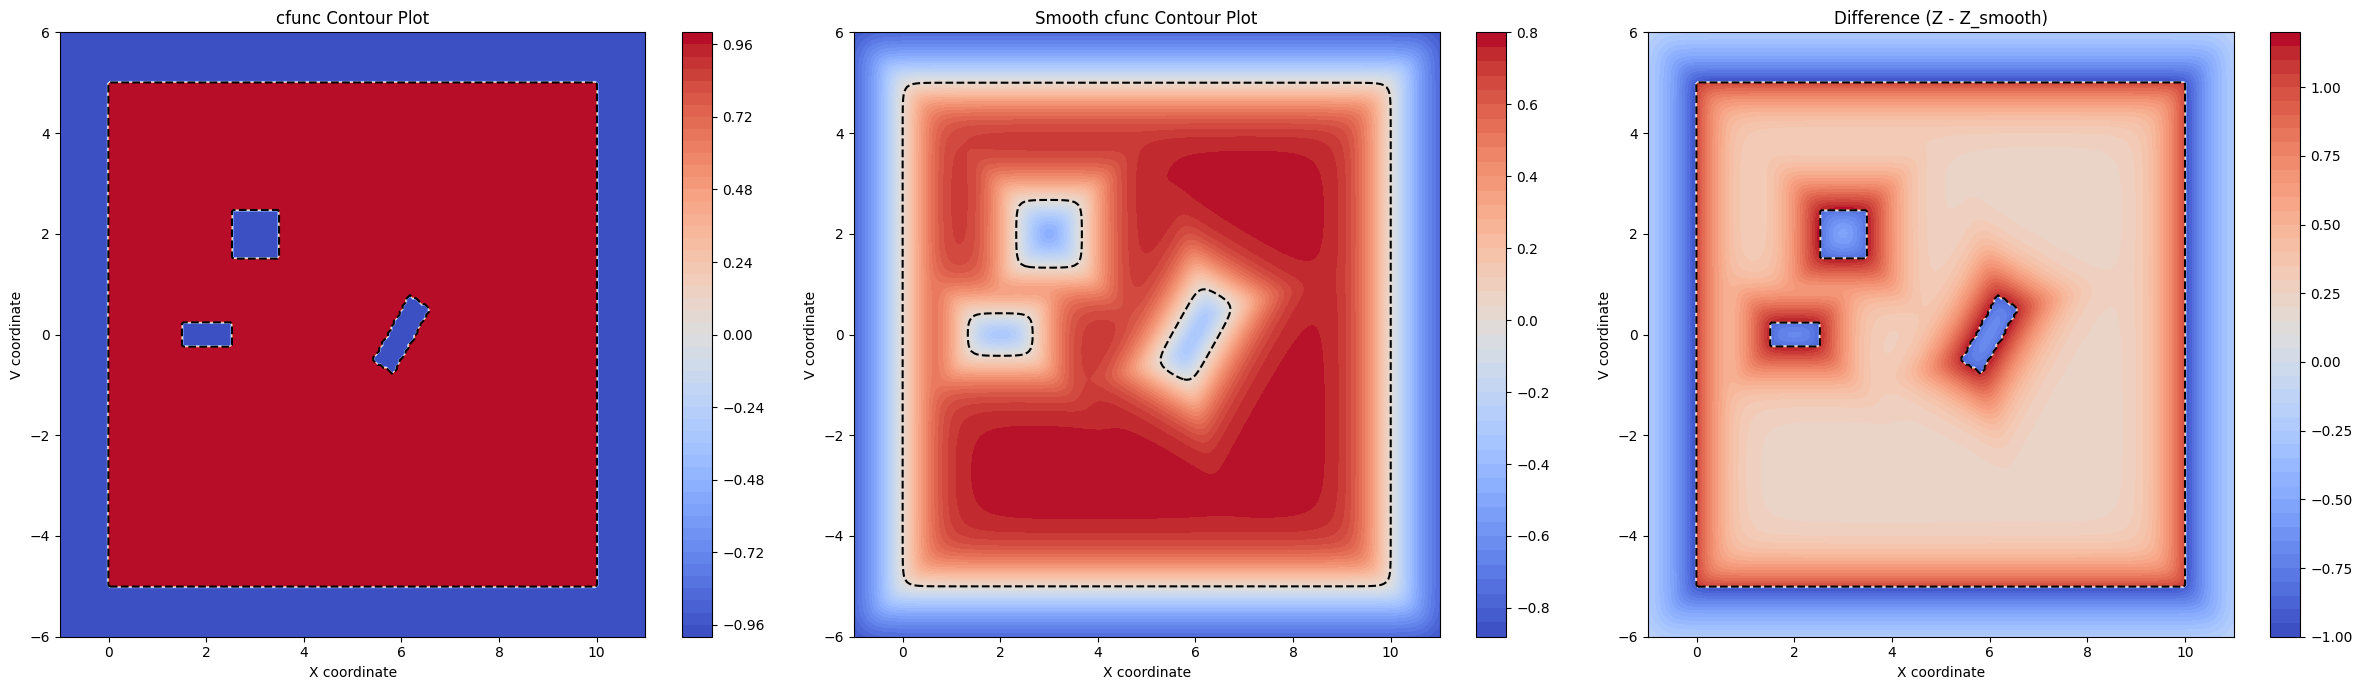

In [ ]:
visualize_cfunc()

In [ ]:
#arbitrary smooth activation van be passed like elu, tanh, silu, softplus, or custom
def MLP(layers, activation=tanh, use_batchnorm=False, init_last_zeros=False, noise_std=1e-8):
    ''' MLP with optional BatchNorm'''
    def init(rng_key):
        def init_layer(key, d_in, d_out, init_zeros=False):
            k1, k2 = random.split(key)
            if init_zeros:
                # W = np.zeros((d_in, d_out))
                # b = np.zeros(d_out)
                W = noise_std * random.normal(k1, (d_in, d_out))
                b = noise_std * random.normal(k2, (d_out,))
            else:
                glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
                W = glorot_stddev * random.normal(k1, (d_in, d_out))
                b = np.zeros(d_out)
            if use_batchnorm:
                # Initialize batchnorm parameters
                scale = np.ones(d_out)
                offset = np.zeros(d_out)
                return W, b, scale, offset
            else:
                return W, b

        key, *keys = random.split(rng_key, len(layers))
        if init_last_zeros:
            params = list(map(init_layer, keys[:-1], layers[:-1], layers[1:], [False]*(len(layers)-1)))
            last_layer_params = init_layer(keys[-1], layers[-2], layers[-1], True)
            params.append(last_layer_params)
        else:
            params = list(map(init_layer, keys, layers[:-1], layers[1:]))
        return params

    def apply(params, inputs, is_training=True):
        for layer_params in params[:-1]:
            W, b = layer_params[:2]  # Get weights and biases
            outputs = np.dot(inputs, W) + b
            if use_batchnorm:
                # Extract batchnorm parameters
                scale, offset = layer_params[2:]
                # Compute batch normalization manually
                mean = np.mean(outputs, axis=0)
                variance = np.var(outputs, axis=0)
                normalized_outputs = (outputs - mean) / np.sqrt(variance + 1e-5)
                outputs = scale * normalized_outputs + offset
            outputs = activation(outputs)
            inputs = outputs
        W, b = params[-1][:2]  # Last layer weights and biases
        outputs = np.dot(inputs, W) + b
        return outputs

    return init, apply

In [ ]:
#This functions like a dataloader
class DataGenerator(data.Dataset):
    def __init__(self, y, c, gradc, batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.y = y  # Queries
        self.c = c  # Safety function values corresponding to queries
        self.gradc = gradc

        self.N = y.shape[0]
        self.batch_size = min(batch_size, self.N)  # Ensure batch_size is smaller than N
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        y, c, gradc = self.__data_generation(subkey)
        return y, c, gradc

    def __len__(self):
        'Denotes the total number of samples'
        return self.N

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        y = self.y[idx, :]
        c = self.c[idx, :]
        gradc = self.gradc[idx, :]

        return y, c, gradc

In [ ]:
#Gradients of cfunc
def get_gradc(y1, y2, rectangles, circles):
    gradc_y1 = grad(smooth_cfunc, argnums=0)(y1, y2, rectangles, circles)
    gradc_y2 = grad(smooth_cfunc, argnums=1)(y1, y2, rectangles, circles)

    # Return the gradients and the Hessian components
    return np.array([gradc_y1, gradc_y2])

#Sampling for counterexample learning
def resample_contour(points, num_points):
    # Parametrically parameterize the path
    t = np.linspace(0, 1, len(points))
    interp_func_x = interp1d(t, points[:, 0], kind='linear')
    interp_func_y = interp1d(t, points[:, 1], kind='linear')

    # Create new parameterization
    t_new = np.linspace(0, 1, num_points)
    x_new = interp_func_x(t_new)
    y_new = interp_func_y(t_new)

    return np.vstack((x_new, y_new)).T

def sample_CBF_boundary(model, n_data, epsilon=epsilon, P = 200):
    #P can be course because of interpolation
    y1 = np.linspace(-1, 11, P)
    y2 = np.linspace(-6, 6, P)
    y1, y2 = np.meshgrid(y1, y2)
    y = np.hstack((y1.flatten()[:, None], y2.flatten()[:, None]))  # shape = (P**2, 2)
    # Evaluate smooth_cfunc over y

    c = vmap(smooth_cfunc, (0, 0, None, None))(y[:, 0], y[:, 1], rectangles, circles)
    outputs = vmap(model.net_diff, (None, 0, 0))(model.get_params(model.opt_state), y[:, 0], y[:, 1])
    h = c - outputs

    # Plot contour and extract zero-level set
    fig, ax = plt.subplots()
    CS = ax.contour(y1, y2, h.reshape(P, P), levels=[0])
    paths = CS.collections[0].get_paths()

    zero_level_points = []
    for path in paths:
        zero_level_points.extend(path.vertices)

    # zero_level_points now contains coordinates of points on the zero level set
    zero_level_points = np.array(zero_level_points)

    plt.close(fig)

    # Choose the number of points you want
    resampled_points = resample_contour(zero_level_points, n_data)

    # Optionally, perturb these points to sample in a band around the zero level set
    key = jax.random.PRNGKey(0)

    perturbed_points = resampled_points + epsilon *  jax.random.normal(key, shape=resampled_points.shape)

    return perturbed_points

def generate_counterexample_training_data(y):
    c = np.expand_dims(vmap(smooth_cfunc, (0, 0, None, None))(y[:, 0], y[:, 1], rectangles, circles), axis = 1)
    gradc = vmap(smooth_cfunc, (0,0, None, None))(y[:, 0], y[:, 1], rectangles, circles)

    return y, c, gradc

def sample_validation_data(P=P_val, rectangles=rectangles, circles=circles, sample_outside=True):
    # Generate a uniform mesh of points
    x_vals = np.linspace(x_min - (1 - sample_outside), x_max + (1 - sample_outside), int(np.sqrt(P)))
    y_vals = np.linspace(y_min - (1 - sample_outside), y_max + (1 - sample_outside), int(np.sqrt(P)))
    mesh = np.array(np.meshgrid(x_vals, y_vals)).T.reshape(-1, 2)  # Reshape into (N, 2)

    if sample_outside:
        # Compute the smooth_cfunc values for all mesh points
        c_values = vmap(smooth_cfunc, (0, 0, None, None))(mesh[:, 0], mesh[:, 1], rectangles, circles)
        # Keep only the points where smooth_cfunc is non-negative (outside obstacles)
        valid_indices = c_values >= 0
        mesh = mesh[valid_indices]

    # Compute values for c and gradc at the remaining mesh points
    c = vmap(smooth_cfunc, (0, 0, None, None))(mesh[:, 0], mesh[:, 1], rectangles, circles)
    gradc = vmap(get_gradc, (0, 0, None, None))(mesh[:, 0], mesh[:, 1], rectangles, circles)

    return mesh, c, gradc

In [ ]:
class NCBF:
    def __init__(self, layers, lambda_0=lambda_0, activation=tanh, output_activation=softplus, use_batchnorm=False, init_last_zeros = False):
        # Network initialization and evaluation functions
        self.init, self.apply = MLP(layers, activation=activation, use_batchnorm=use_batchnorm, init_last_zeros=init_last_zeros)
        self.lambda_0 = lambda_0
        self.output_activation = output_activation

        # Initialize
        params = self.init(rng_key=random.PRNGKey(1234))

        # Use optimizers to set optimizer initialization and update functions
        self.opt_init, self.opt_update, self.get_params = optimizers.adam(optimizers.exponential_decay(ilr, decay_steps=decay_steps, decay_rate=decay_rate))

        # Initialize optimizer state for both phases
        self.opt_state = self.opt_init(params)

        self.itercount = itertools.count()

        self.nIter = int(descent_steps * (border_samples / batch_size))

        # Logger
        self.loss_log = []

    def update_nIter(self):
        self.nIter = int(descent_steps * (border_samples / batch_size))

    def plot_losses(self):
        # Plotting losses
        plt.figure(figsize=(12, 6))
        plt.plot(self.loss_log, label='Loss', color='blue')

        # Labels and Legends
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.legend()

        # Show plot
        plt.show()

    #Plotting function for test
    def plot_predictions(self, P = 200):
        y1 = np.linspace(-1, 11, P)
        y2 = np.linspace(-6, 6, P)
        y1, y2 = np.meshgrid(y1, y2)
        y = np.hstack((y1.flatten()[:, None], y2.flatten()[:, None]))  # shape = (P**2, 2)
        # Evaluate smooth_cfunc over y

        c = vmap(smooth_cfunc, (0, 0, None, None))(y[:, 0], y[:, 1], rectangles, circles)
        # Plotting
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))  # Adjusted for three plots

        # Plot c
        cp1 = ax[0].contourf(y1, y2, c.reshape(P, P), levels=50, cmap='coolwarm')
        contour1 = ax[0].contour(y1, y2, c.reshape(P, P), levels=[0], colors='black')
        fig.colorbar(cp1, ax=ax[0])
        ax[0].set_title('cfunc Contour Plot')
        ax[0].set_xlabel('x')
        ax[0].set_ylabel('v')

        # Generate predictions for CBF
        params = self.get_params(self.opt_state)
        outputs = vmap(self.net_diff, (None, 0, 0))(params, y[:, 0], y[:, 1])

        h = c - outputs

        # Plot CBF
        cp2 = ax[1].contourf(y1, y2, h.reshape(P, P), levels=50, cmap='coolwarm')
        contour2 = ax[1].contour(y1, y2, h.reshape(P, P), levels=[0], colors='black')
        fig.colorbar(cp2, ax=ax[1])
        ax[1].set_title('CBF')
        ax[1].set_xlabel('x')
        ax[1].set_ylabel('v')

        plt.tight_layout()
        plt.show()

    def net_diff(self, params, y1, y2):
        input_vector = np.hstack([y1, y2])
        out = np.squeeze(self.apply(params, input_vector))
        output = self.output_activation(out)

        return output

    def get_grad_delta(self, y1, y2):
        params = self.get_params(self.opt_state)
        delta_y1 = grad(self.net_diff, argnums=1)(params, y1, y2)
        delta_y2 = grad(self.net_diff, argnums=2)(params, y1, y2)

        # Return the spatial gradient components
        return np.array([delta_y1, delta_y2])

    def derivative_h(self, dc, ddelta):
        return dc  -  ddelta

    #Residuals Used for validation
    def residuals(self, params, y1, y2, c, c_y1, c_y2, gamma=gamma):
        delta = self.net_diff(params, y1, y2)
        delta_y1 = grad(self.net_diff, argnums=1)(params, y1, y2)
        delta_y2 = grad(self.net_diff, argnums=2)(params, y1, y2)
        h = c - delta

        h_y1 = self.derivative_h(c_y1, delta_y1)
        h_y2 = self.derivative_h(c_y2, delta_y2)

        res_I = np.min(np.array([delta, y2 * h_y1 + u * np.abs(h_y2) + gamma * h]))
        res_II = relu(- y2 * h_y1 - u * np.abs(h_y2) - gamma * h)

        return np.array([res_I, res_II])


    def saturation_risk(self, params, y1, y2, c, c_y1, c_y2):
        delta_y1 = grad(self.net_diff, argnums=1)(params, y1, y2)
        delta_y2 = grad(self.net_diff, argnums=2)(params, y1, y2)

        h_y1 = self.derivative_h(c_y1, delta_y1)
        h_y2 = self.derivative_h(c_y2, delta_y2)

        return - y2 * h_y1 - u * np.abs(h_y2)

    def volume_regularization(self, params, y1, y2, c, c_y1, c_y2):
        delta = self.net_diff(params, y1, y2)
        h = c - delta
        return sigmoid(-h)

    def loss(self, params, batch):
        # Fetch data
        y, c, gradc = batch
        c_squeeze = np.squeeze(c)
        # Compute forward pass
        srs = vmap(self.saturation_risk, (None, 0, 0, 0, 0, 0))(params, y[:, 0], y[:, 1], c_squeeze, gradc[:, 0], gradc[:, 1])
        vrr = vmap(self.volume_regularization, (None, 0, 0, 0, 0, 0))(params, y[:, 0], y[:, 1], c_squeeze, gradc[:, 0], gradc[:, 1])
        # Compute loss
        loss = np.mean(relu(srs)) + lambda_0 * np.mean(vrr)
        return loss

    # Define a compiled update step for phase
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, batch)
        return self.opt_update(i, g, opt_state)

    def train(self, train_dataset):
        data = iter(train_dataset)

        pbar = trange(self.nIter)
        for it in pbar:
            batch = next(data)

            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)

            if it % 100 == 0:
                params = self.get_params(self.opt_state)

                # Compute and store losses
                loss_value = self.loss(params, batch)
                self.loss_log.append(loss_value)
                # Print losses
                pbar.set_postfix({'Train Loss': loss_value})


In [ ]:
def validation(model, y_val, c_val, gradc_val, gamma=gamma):
        ndata = y_val.shape[0]
        params = model.get_params(model.opt_state)

        res_both = vmap(model.residuals, (None, 0, 0, 0, 0, 0))(params, y_val[:,0], y_val[:,1], c_val, gradc_val[:,0], gradc_val[:,1])

        res_I = res_both[:,0]
        res_II = res_both[:,1]
        abs_res_I = np.abs(res_I)

        delta_val = vmap(model.net_diff, (None, 0, 0))(params, y_val[:,0], y_val[:,1])
        h_val = c_val - delta_val

        # Compute relative volume
        rel_vol = np.mean(h_val >= 0)

        # Compute other metrics
        avg_abs_res_I = np.mean(abs_res_I)
        max_abs_res_I = np.max(abs_res_I)
        std_abs_res_I = np.std(abs_res_I)
        avg_safety = np.mean(res_II)

        # Print the calculated values
        print(f"Average of abs_res_I: {avg_abs_res_I}")
        print(f"Maximum of abs_res_I: {max_abs_res_I}")
        print(f"Standard deviation of abs_res_I: {std_abs_res_I}")
        print(f"Average of safety: {avg_safety}")
        print(f"Relative volume: {rel_vol}")

In [ ]:
epochs = 50
descent_steps = 10
border_samples = 10000
DI_NCBF = NCBF(layers, lambda_0=0, activation=tanh, output_activation=softplus, use_batchnorm=False, init_last_zeros = False)

100%|██████████| 100/100 [00:02<00:00, 36.72it/s, Train Loss=1.1207693]


Epoch 1/50


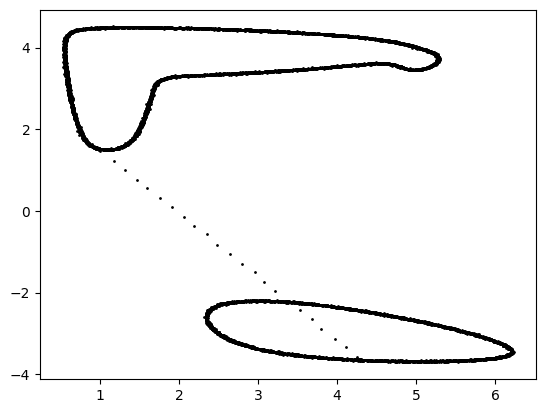

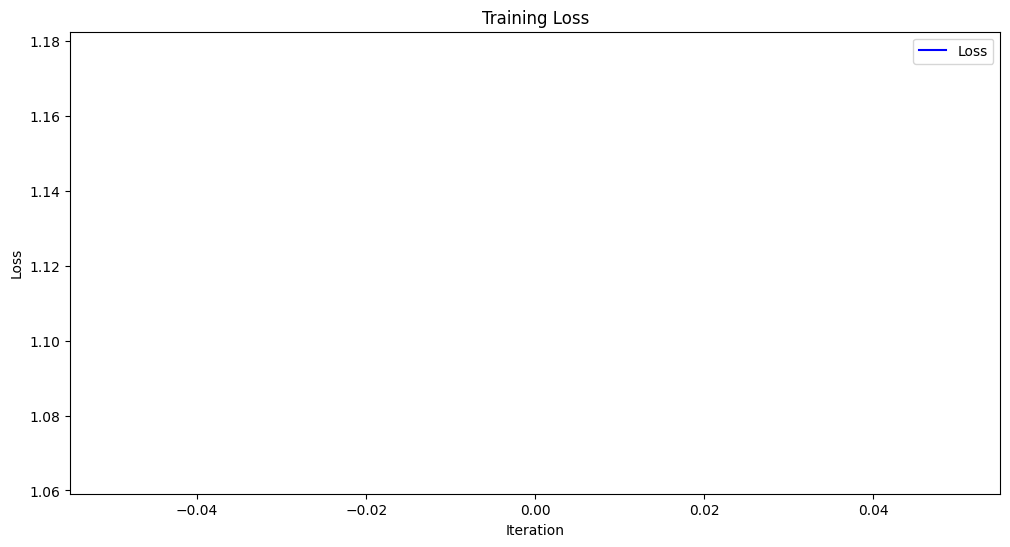

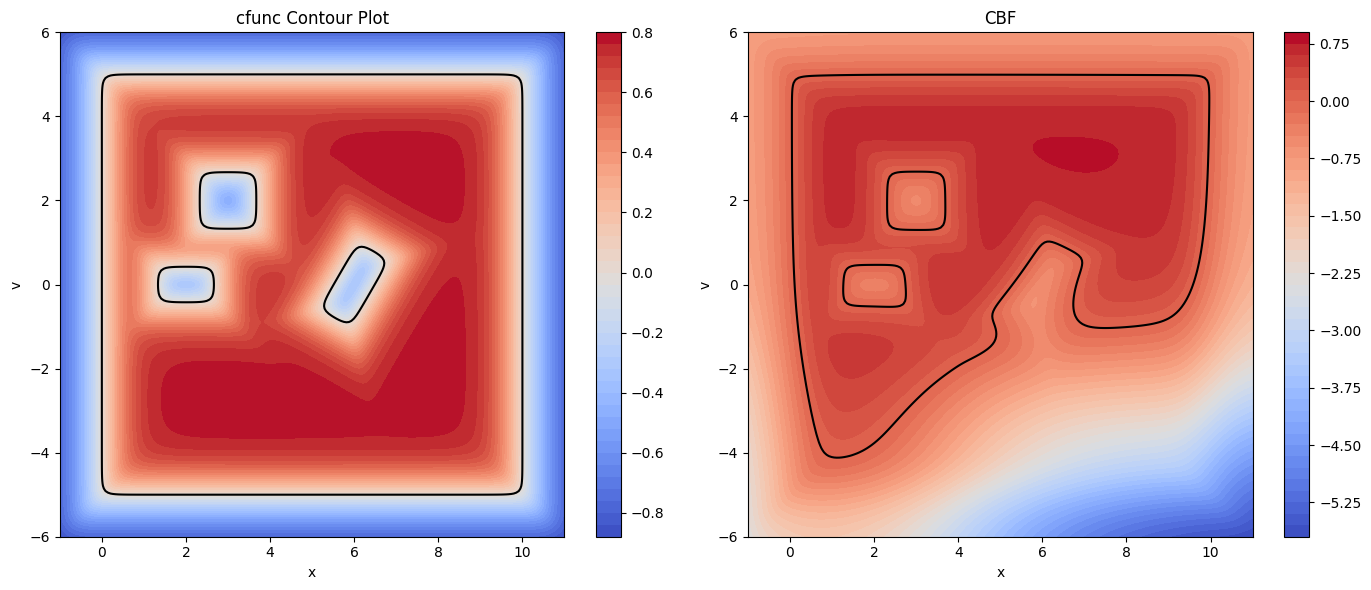

100%|██████████| 100/100 [00:01<00:00, 63.68it/s, Train Loss=0.5043553]


Epoch 11/50


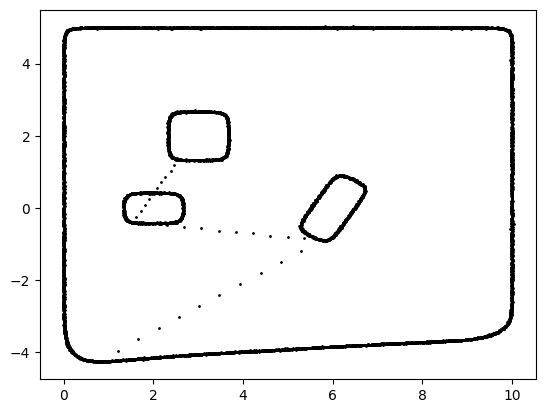

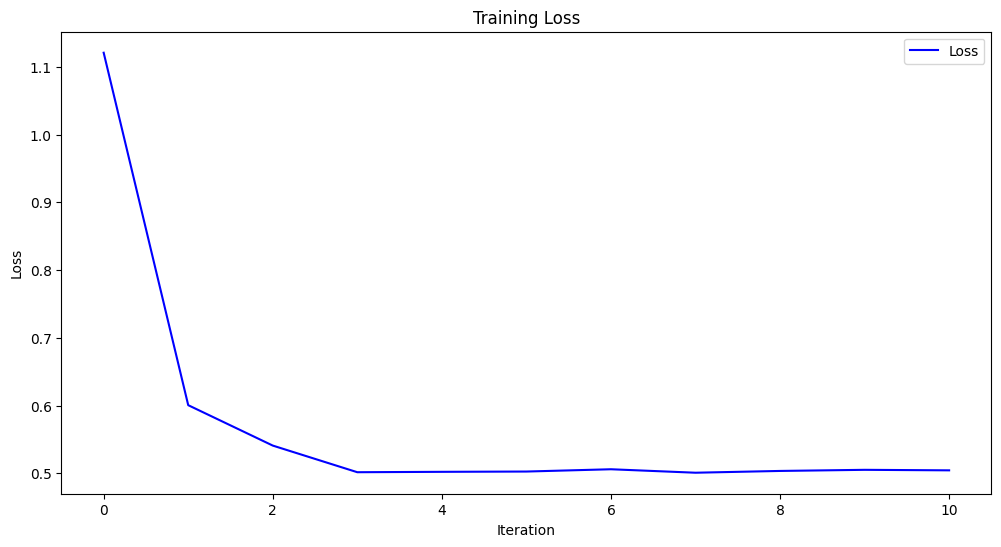

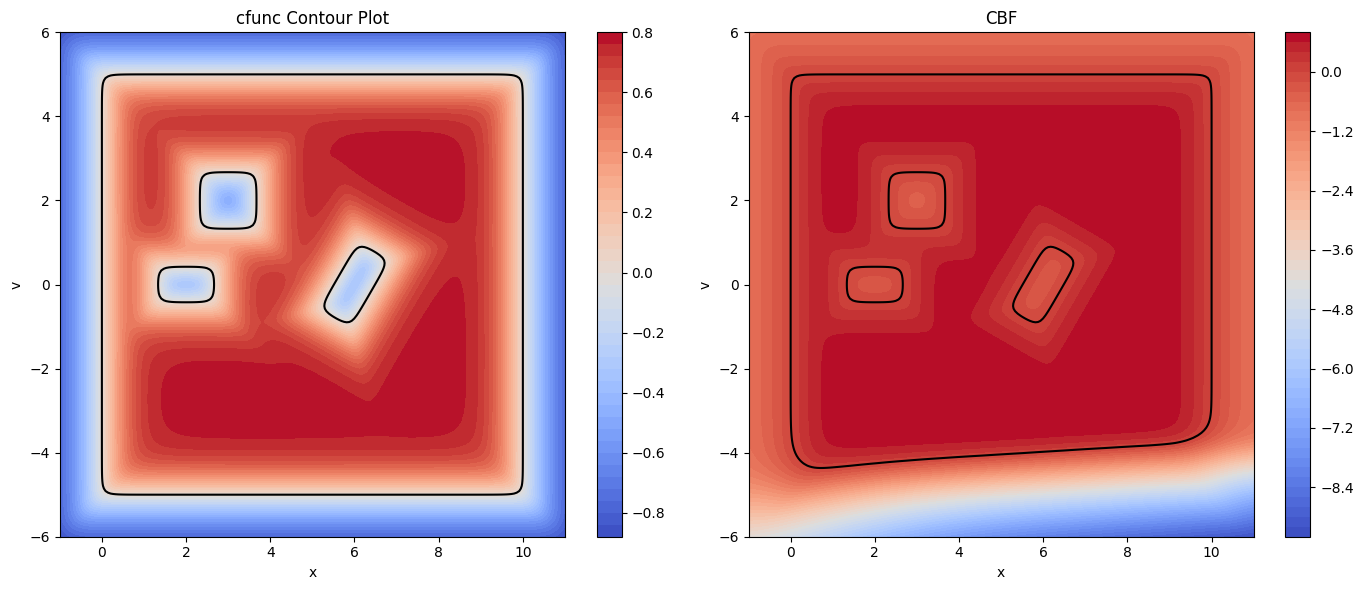

100%|██████████| 100/100 [00:02<00:00, 39.96it/s, Train Loss=0.5054479]


Epoch 21/50


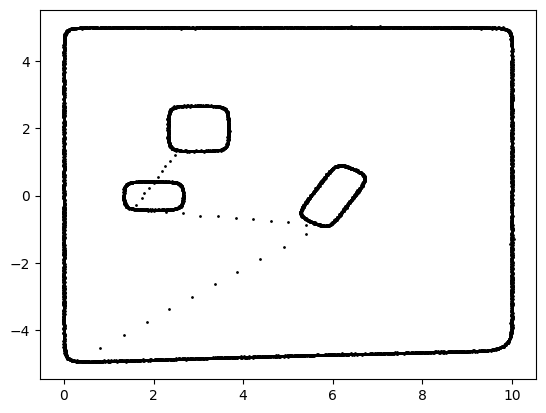

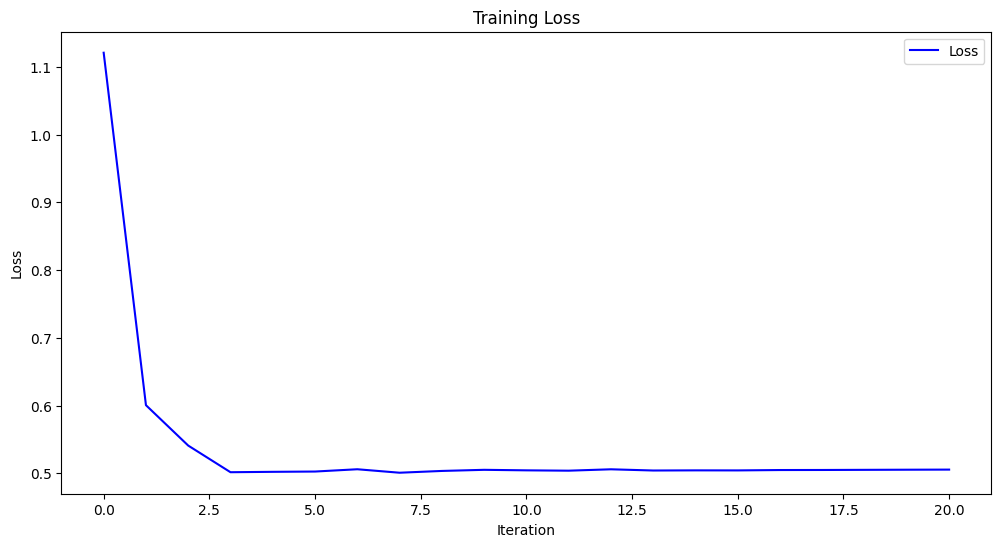

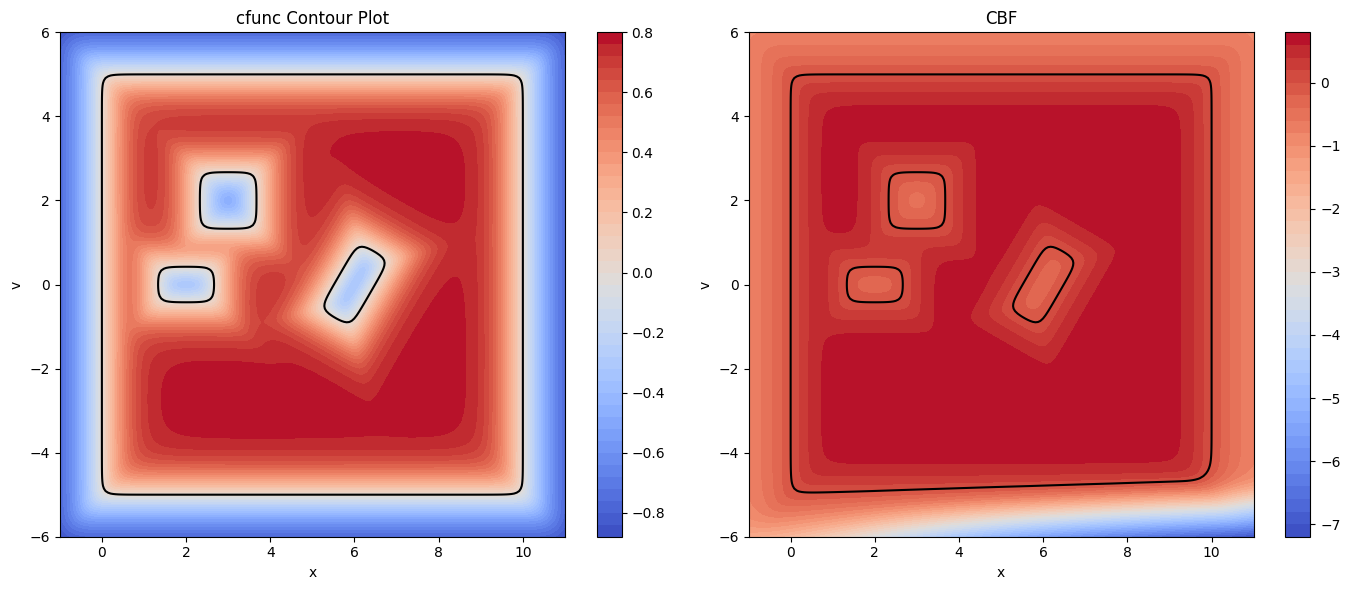

100%|██████████| 100/100 [00:01<00:00, 64.69it/s, Train Loss=0.5061319]


Epoch 31/50


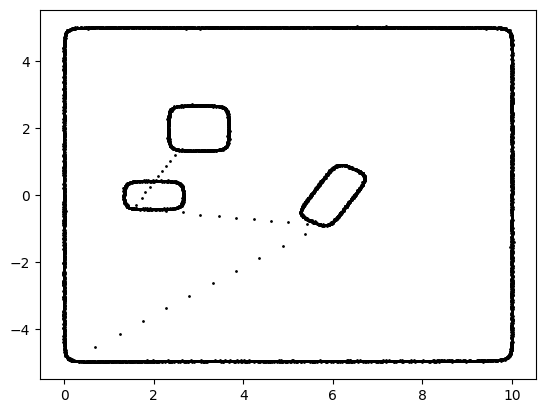

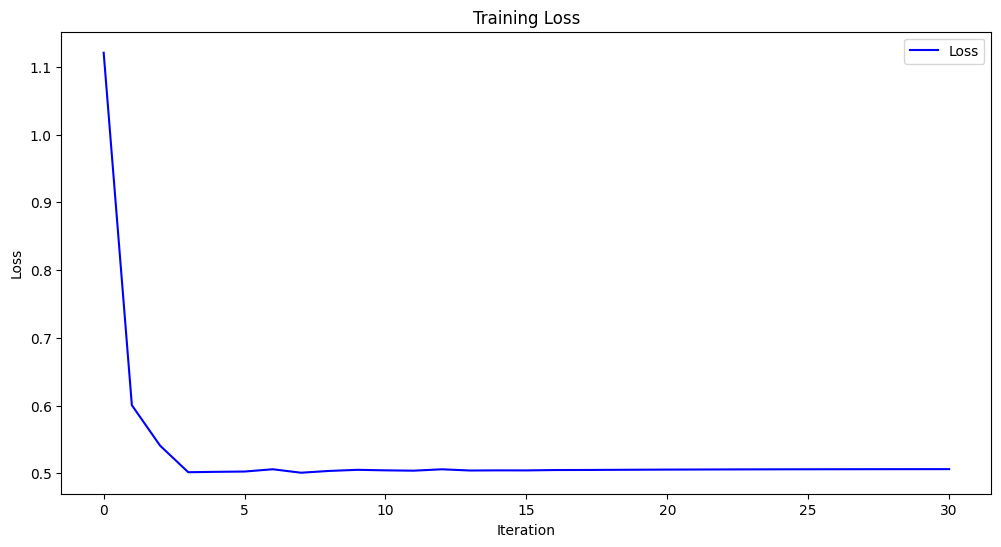

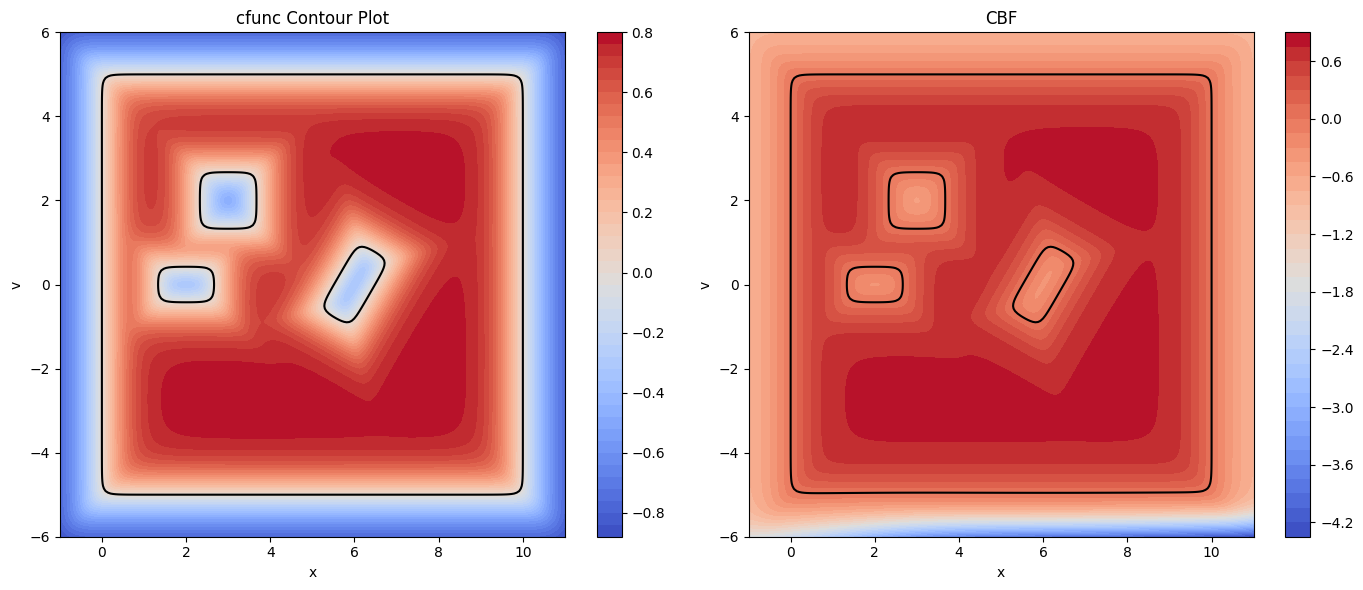

100%|██████████| 100/100 [00:02<00:00, 47.01it/s, Train Loss=0.5061897]


Epoch 41/50


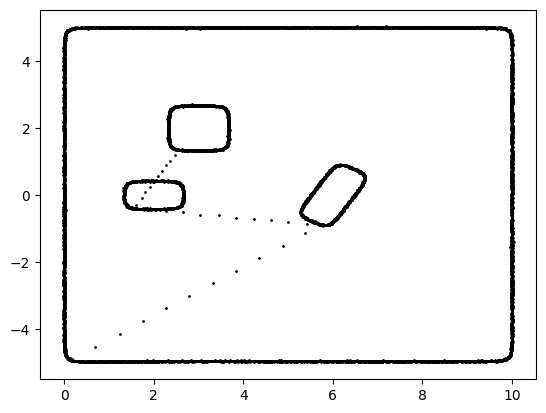

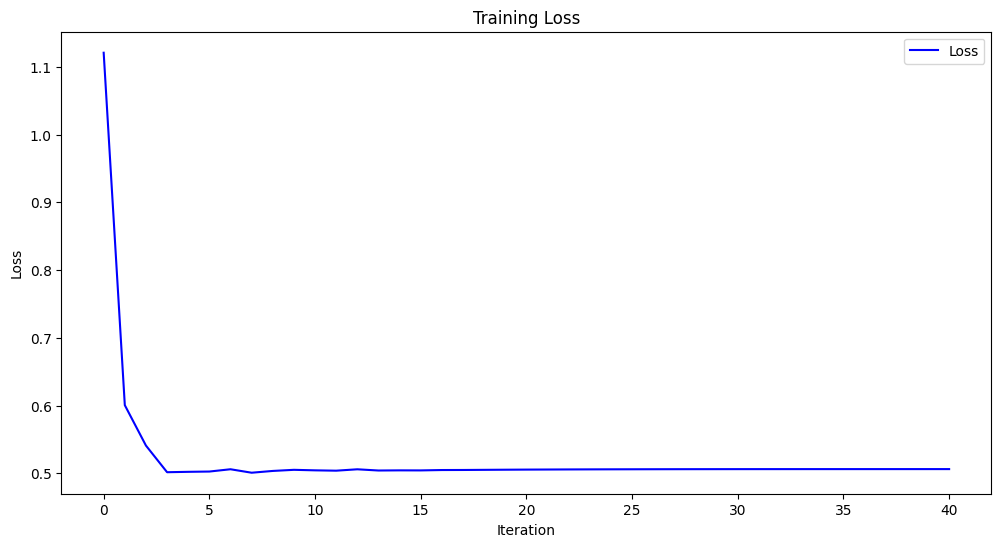

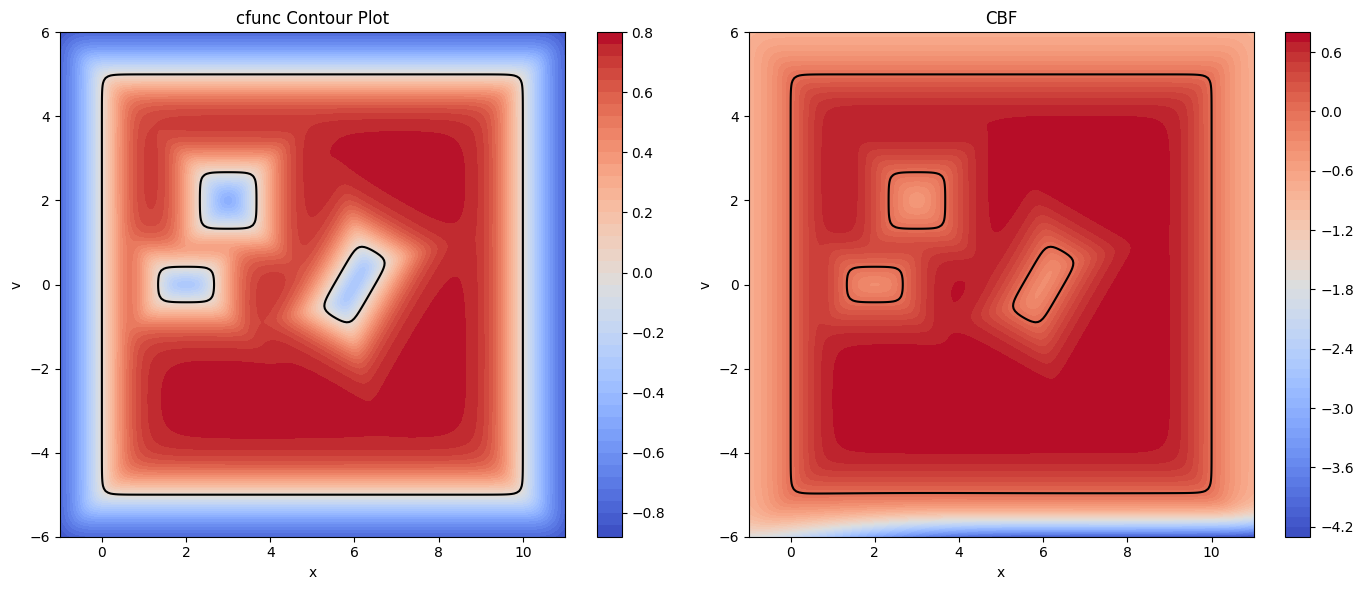

100%|██████████| 100/100 [00:01<00:00, 64.64it/s, Train Loss=0.5062291]


In [ ]:
for epoch in range(epochs):
    boundary_points = sample_CBF_boundary(DI_NCBF, border_samples)
    y_counter, c_counter, gradc_counter = generate_counterexample_training_data(boundary_points)
    current_dataset = DataGenerator(y_counter, c_counter, np.expand_dims(gradc_counter, axis = 1), batch_size=border_samples)


    # Train the model on the current dataset
    DI_NCBF.train(current_dataset)

    # Plot losses and predictions every 100 epochs
    if epoch % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs}")
        plt.scatter(boundary_points[:,0], boundary_points[:,1], color='black', s=1)  # Plot perturbed points)
        DI_NCBF.plot_losses()
        DI_NCBF.plot_predictions()

In [ ]:
y_val_outside, c_val_outside, gradc_val_outside = sample_validation_data(sample_outside=True)


In [ ]:
validation(DI_NCBF, y_val_outside, c_val_outside, gradc_val_outside)

Average of abs_res_I: 0.17775824666023254
Maximum of abs_res_I: 4.323802471160889
Standard deviation of abs_res_I: 0.5729270577430725
Average of safety: 0.17728856205940247
Relative volume: 0.9987499117851257
